In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import string
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords,wordnet
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# *Loading Data*

In [3]:
df = pd.read_csv('/kaggle/input/spam-email/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df.isnull().sum()


Category    0
Message     0
dtype: int64

In [6]:
df.groupby("Category").describe() 

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

# *Text Visualization*



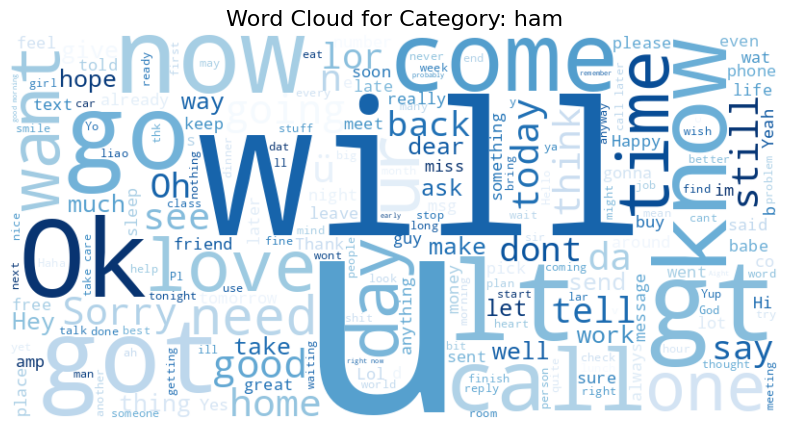

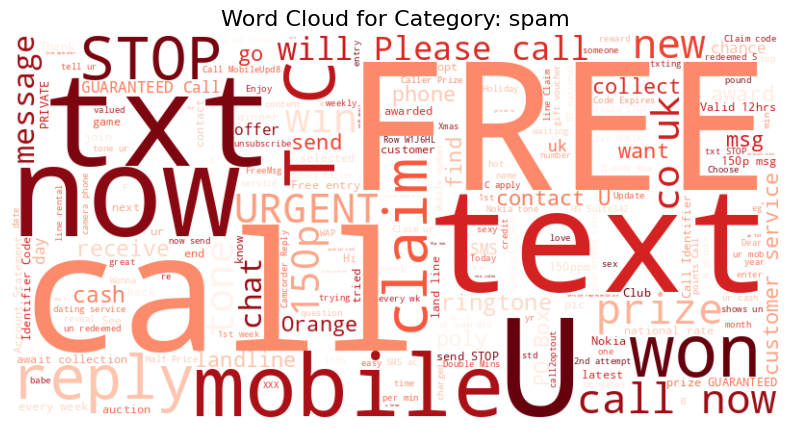

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Define custom colormaps for each category
colors = {'spam': 'Reds', 'ham': 'Blues'}

for category in df['Category'].unique():
    filtered_df = df[df['Category'] == category]
    
    text = ' '.join(filtered_df['Message'])
    
    # Generate the word cloud with appropriate color and stopwords removal
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colors[category.lower()],
        stopwords=STOPWORDS
    ).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}', fontsize=16)
    plt.axis('off')
    plt.show()


In [8]:
#Creating a Binary Spam Indicator Column from Category Labels

df["spam"]= df["Category"].apply(lambda x: 1 if x== "spam" else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# *Preprocessing*

In [9]:
# Convert 'Text' column to lowercase
df['Message'] = df['Message'].str.lower()
df.head()

,Category,Message,spam
0,ham,"go until jurong point, crazy.. available only ...",0
1,ham,ok lar... joking wif u oni...,0
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1
3,ham,u dun say so early hor... u c already then say...,0
4,ham,"nah i don't think he goes to usf, he lives aro...",0


In [10]:
# Remove extra white spaces from the 'Text' column
df['Message'] = df['Message'].str.strip()
df.head()

,Category,Message,spam
0,ham,"go until jurong point, crazy.. available only ...",0
1,ham,ok lar... joking wif u oni...,0
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1
3,ham,u dun say so early hor... u c already then say...,0
4,ham,"nah i don't think he goes to usf, he lives aro...",0


In [11]:
string.punctuation

# Define the punctuation characters to remove
punctuation = string.punctuation

In [12]:
# Function to remove punctuation from text
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

# Apply remove_punctuation function to 'Text' column
df['Message'] = df['Message'].apply(remove_punctuation)

df.head()

,Category,Message,spam
0,ham,go until jurong point crazy available only in ...,0
1,ham,ok lar joking wif u oni,0
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1
3,ham,u dun say so early hor u c already then say,0
4,ham,nah i dont think he goes to usf he lives aroun...,0


In [13]:
# Function to remove numeric values from text
def remove_numeric(text):
    return re.sub(r'\d+', '', text)

# Apply the function to the "Message" column
df['Message'] = df['Message'].apply(remove_numeric)
df.head()

,Category,Message,spam
0,ham,go until jurong point crazy available only in ...,0
1,ham,ok lar joking wif u oni,0
2,spam,free entry in a wkly comp to win fa cup final...,1
3,ham,u dun say so early hor u c already then say,0
4,ham,nah i dont think he goes to usf he lives aroun...,0


In [14]:
# Download NLTK stopwords corpus
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'Text' column
df['Message'] = df['Message'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Apply lemmatization to the Message column
lemmatizer = WordNetLemmatizer()

df['Message_lemmatized'] = df['Message'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)
df.head()

,Category,Message,spam,Message_lemmatized
0,ham,go jurong point crazy available bugis n great ...,0,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni,0,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...,1,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say,0,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though,0,nah dont think go usf life around though


# *Model Building*

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Message_lemmatized'], 
    df.spam, 
    stratify=df.spam, 
    test_size=0.2, 
    random_state=42
)

In [17]:
X_train

184                                             guy close
2171    please come imin towndontmatter urgoin outlrju...
5422                            ok ksry knw sivatats askd
4113                                  ill see prolly yeah
4588          ill see swing bit got thing take care firsg
                              ...                        
1932                                    pa tell went bath
5316                             jus finish watching tv u
2309    moby pub quizwin £ high street prize u know ne...
1904    free entry weekly comp chance win ipod txt pod...
762     grandma oh dear u still ill felt shit morning ...
Name: Message_lemmatized, Length: 4457, dtype: object

In [18]:
X_train.describe() 

count                     4457
unique                    4123
top       sorry ill call later
freq                        25
Name: Message_lemmatized, dtype: object

In [19]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)


In [20]:
X_train_vec 
# We have 4,457 training messages
# Each message is transformed into a feature vector of size 6,978 (unique words)


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 36091 stored elements and shape (4457, 6981)>

In [21]:
# Logistic Regression with tuned parameters
lr_model = LogisticRegression(C=0.1, solver='liblinear', max_iter=500)
lr_model.fit(X_train_vec, y_train)

# Predict on test set (note: use X_test_vec, not X_test)
lr_pred = lr_model.predict(X_test_vec)


# Multinomial Naive Bayes with tuned parameters
mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(X_train_vec, y_train)
mnb_pred = mnb_model.predict(X_test_vec)

# Support Vector Machines (SVM) with tuned parameters
svm_model = SVC(C=10.0, kernel='rbf', gamma='auto')
svm_model.fit(X_train_vec, y_train)
svm_pred = svm_model.predict(X_test_vec)

# Random Forests with tuned parameters
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10)
rf_model.fit(X_train_vec, y_train)
rf_pred = rf_model.predict(X_test_vec)

# XGBoost Classifier with tuned parameters
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_vec, y_train)
xgb_pred = xgb_model.predict(X_test_vec)

# *Models Evaluation*

In [22]:
# Function to calculate metrics
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

# Evaluate all models
results = [
    evaluate_model('Logistic Regression', y_test, lr_pred),
    evaluate_model('Naive Bayes', y_test, mnb_pred),
    evaluate_model('SVM', y_test, svm_pred),
    evaluate_model('Random Forest', y_test, rf_pred),
    evaluate_model('XGBoost', y_test, xgb_pred)
]

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)  # Sort by best F1
results_df.reset_index(drop=True, inplace=True)

# Display the evaluation table
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Naive Bayes,0.975785,0.923611,0.892617,0.907850
1,Logistic Regression,0.966816,1.000000,0.751678,0.858238
2,XGBoost,0.965919,0.974359,0.765101,0.857143
3,Random Forest,0.924664,1.000000,0.436242,0.607477
4,SVM,0.913004,1.000000,0.348993,0.517413


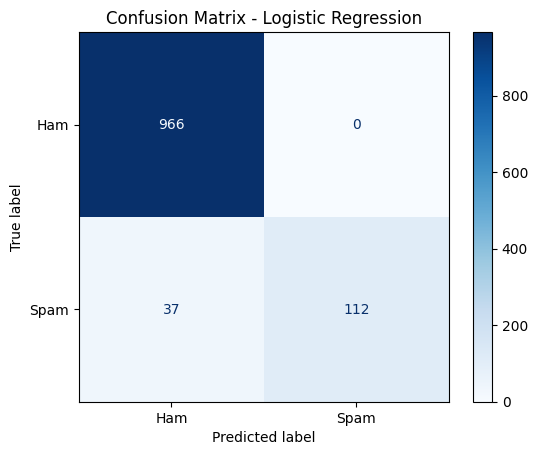

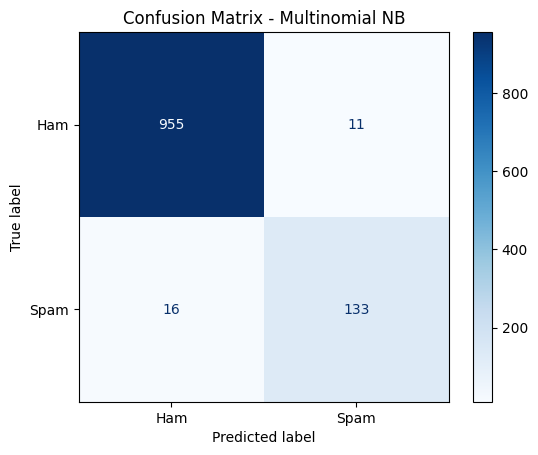

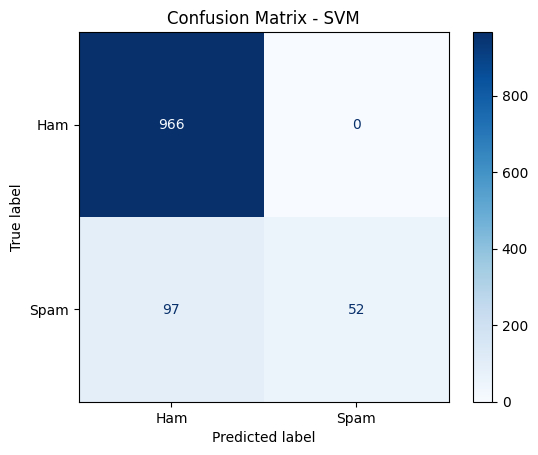

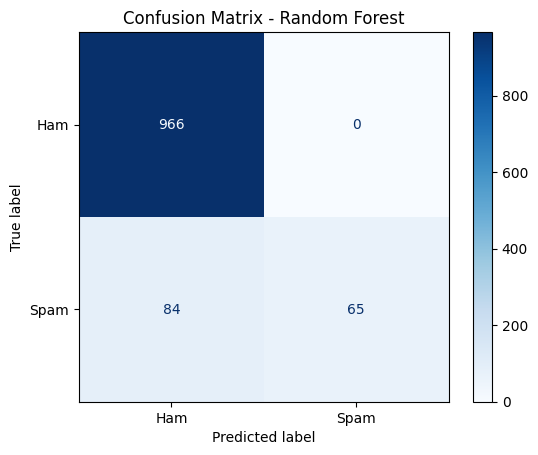

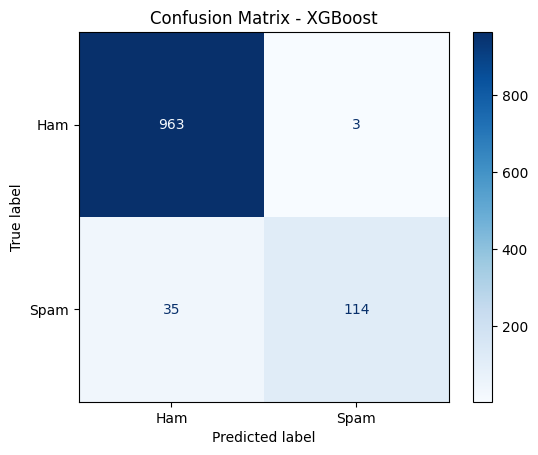

In [23]:
# Define the models and their predictions
model_predictions = {
    "Logistic Regression": lr_pred,
    "Multinomial NB": mnb_pred,
    "SVM": svm_pred,
    "Random Forest": rf_pred,
    "XGBoost": xgb_pred
}

# Plot Confusion Matrix for each model
for model_name, preds in model_predictions.items():
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.show()


In [24]:
messages = [
    "congratulations! you've won a free ticket to Bahamas",   # spam
    "hey, are we still meeting tomorrow?",                     # ham
    "urgent! claim your prize now",                            # spam
    "let's catch up over coffee this week",                    # ham
    "win cash prizes by entering this contest"                 # spam
]

# True labels: 1 = Spam, 0 = Ham
true_labels = [1, 0, 1, 0, 1]


messages_vec = cv.transform(messages)

models = {
    "Logistic Regression": lr_model,
    "Multinomial NB": mnb_model,
    "SVM": svm_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

for model_name, model in models.items():
    preds = model.predict(messages_vec)
    print(f"\nPredictions by {model_name}:")
    for msg, pred, true_label in zip(messages, preds, true_labels):
        pred_label = "Spam" if pred == 1 else "Ham"
        true_label_str = "Spam" if true_label == 1 else "Ham"
        print(f"Message: \"{msg}\" --> Prediction: {pred_label} | True: {true_label_str}")



Predictions by Logistic Regression:
Message: "congratulations! you've won a free ticket to Bahamas" --> Prediction: Ham | True: Spam
Message: "hey, are we still meeting tomorrow?" --> Prediction: Ham | True: Ham
Message: "urgent! claim your prize now" --> Prediction: Ham | True: Spam
Message: "let's catch up over coffee this week" --> Prediction: Ham | True: Ham
Message: "win cash prizes by entering this contest" --> Prediction: Ham | True: Spam

Predictions by Multinomial NB:
Message: "congratulations! you've won a free ticket to Bahamas" --> Prediction: Spam | True: Spam
Message: "hey, are we still meeting tomorrow?" --> Prediction: Ham | True: Ham
Message: "urgent! claim your prize now" --> Prediction: Spam | True: Spam
Message: "let's catch up over coffee this week" --> Prediction: Ham | True: Ham
Message: "win cash prizes by entering this contest" --> Prediction: Spam | True: Spam

Predictions by SVM:
Message: "congratulations! you've won a free ticket to Bahamas" --> Prediction:

In [25]:
# Create a list of dictionaries with train and test accuracy for each model
accuracy_data = [
    {"Model": "Logistic Regression", "Train Accuracy": lr_model.score(X_train_vec, y_train), "Test Accuracy": accuracy_score(y_test, lr_pred)},
    {"Model": "Multinomial NB", "Train Accuracy": mnb_model.score(X_train_vec, y_train), "Test Accuracy": accuracy_score(y_test, mnb_pred)},
    {"Model": "SVM", "Train Accuracy": svm_model.score(X_train_vec, y_train), "Test Accuracy": accuracy_score(y_test, svm_pred)},
    {"Model": "Random Forest", "Train Accuracy": rf_model.score(X_train_vec, y_train), "Test Accuracy": accuracy_score(y_test, rf_pred)},
    {"Model": "XGBoost", "Train Accuracy": xgb_model.score(X_train_vec, y_train), "Test Accuracy": accuracy_score(y_test, xgb_pred)},
]

# Convert to DataFrame
acc_df = pd.DataFrame(accuracy_data)


In [26]:
for index, row in acc_df.iterrows():
    print(f"Model: {row['Model']}")
    print(f"  Train Accuracy: {row['Train Accuracy']:.4f}")
    print(f"  Test Accuracy: {row['Test Accuracy']:.4f}")
    print('-' * 30)


Model: Logistic Regression
  Train Accuracy: 0.9758
  Test Accuracy: 0.9668
------------------------------
Model: Multinomial NB
  Train Accuracy: 0.9933
  Test Accuracy: 0.9758
------------------------------
Model: SVM
  Train Accuracy: 0.9116
  Test Accuracy: 0.9130
------------------------------
Model: Random Forest
  Train Accuracy: 0.9266
  Test Accuracy: 0.9247
------------------------------
Model: XGBoost
  Train Accuracy: 0.9733
  Test Accuracy: 0.9659
------------------------------


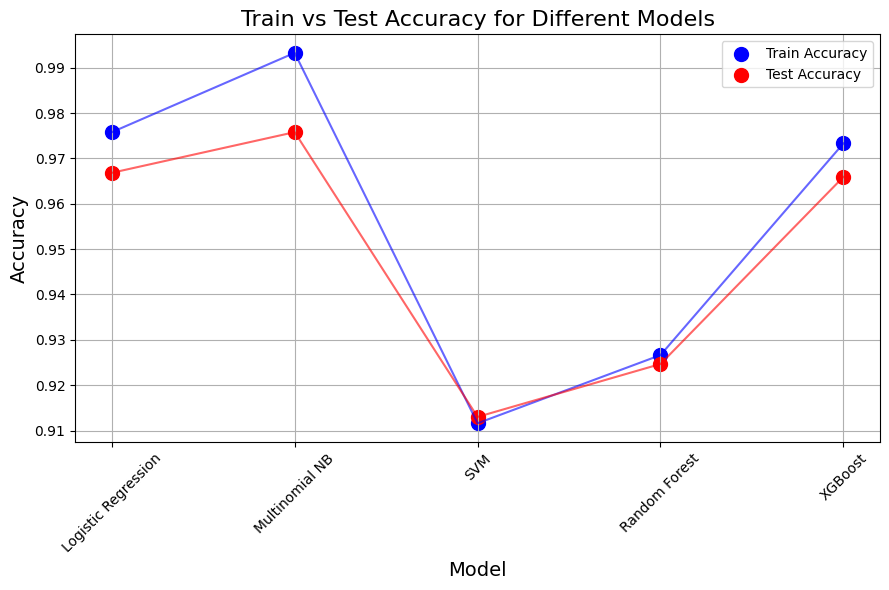

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))

# Plot train accuracy points and connect them with a line
plt.scatter(acc_df['Model'], acc_df['Train Accuracy'], color='blue', label='Train Accuracy', s=100)
plt.plot(acc_df['Model'], acc_df['Train Accuracy'], color='blue', linestyle='-', alpha=0.6)

# Plot test accuracy points and connect them with a line
plt.scatter(acc_df['Model'], acc_df['Test Accuracy'], color='red', label='Test Accuracy', s=100)
plt.plot(acc_df['Model'], acc_df['Test Accuracy'], color='red', linestyle='-', alpha=0.6)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Train vs Test Accuracy for Different Models', fontsize=16)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import joblib
joblib.dump(mnb_model, "best_model_mnb.pkl")
joblib.dump(cv, "vectorizer.pkl")


['vectorizer.pkl']